# Method Overview

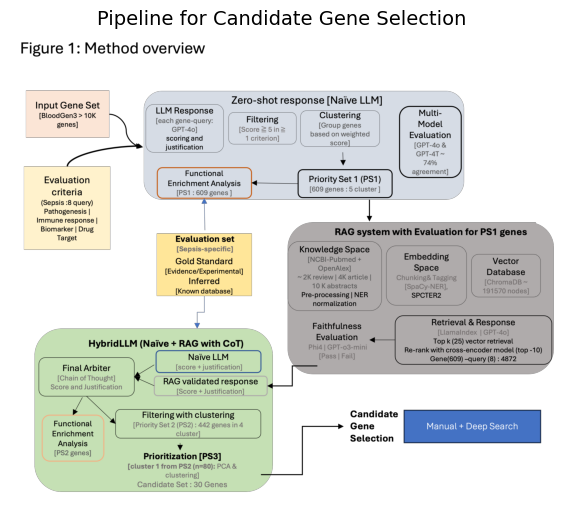

In [2]:
# display figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
figure1 = "Figures/Figure1_CandidateGeneSelection_workflow.png"
# Path to your PNG image (update filename as needed)

img = mpimg.imread(figure1)
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')
plt.title('Pipeline for Candidate Gene Selection', fontsize=14)
plt.show()


# Prepare for PS1 : generate naive response

## Setup API connections to access any frontier model.
Here we use Azure to access openAI

In [3]:
from openai import AzureOpenAI
from tenacity import retry, stop_after_attempt, wait_exponential
import asyncio, logging, tiktoken

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s")
logging.getLogger("httpx").setLevel(logging.WARNING)

MODEL_COST = {"gpt-4o": {"input": 0.005, "output": 0.015}}

def count_tokens(text, model="gpt-4o"):
    return len(tiktoken.encoding_for_model(model).encode(text))

def count_message_tokens(system_prompt, user_prompt, model="gpt-4o"):
    return count_tokens(system_prompt, model) + 4 + count_tokens(user_prompt, model) + 4

client = AzureOpenAI(
    api_version="",  # specify the API version
    azure_endpoint=",", # specify the Azure OpenAI endpoint
    api_key=""  # specify your Azure OpenAI API key
)

@retry(wait=wait_exponential(multiplier=1, min=1, max=512), stop=stop_after_attempt(20))
async def completion_with_backoff(**kwargs):
    return client.chat.completions.create(**kwargs)

## Prepare query

the prompt query can be designed with great flexibility, keeping the context and problem in mind

In [4]:
# Queries
p_query = {
    'sepsis_pathogenesis': "is associated with the pathogenesis of sepsis. Score: Based on evidence of the gene's involvement in the biological processes underlying sepsis, including but not limited to its role in the dysregulated host response to infection, organ dysfunction, or sepsis-related complications",
    'sepsis_immune': "is associated with the host immune response in sepsis. Score: Based on evidence of the gene's involvement in the immune response during sepsis, including but not limited to its role in innate or adaptive immunity, inflammation, or immunosuppression",
    'sepsis_organ': "is associated with sepsis-related organ dysfunction. Score: Based on evidence of the gene's involvement in the development or progression of organ dysfunction in sepsis, including but not limited to its role in cardiovascular, respiratory, renal, hepatic, or neurological dysfunction",
    'sepsis_circulating leukocytes immune': "is associated with the immune response of circulating leukocytes in sepsis. Score: Based on evidence of the gene's involvement in the immune response of circulating leukocytes during sepsis, including but not limited to its role in leukocyte activation, migration, or function",
    'sepsis_biomarker_clinic': "or its products are currently being used as a biomarker for sepsis in clinical settings. Score: Based on evidence of the gene or its products' application as biomarkers for diagnosis, prognosis, or monitoring of sepsis in clinical settings, with a focus on their validated use and acceptance in medical practice",
    'sepsis_biomarker_blood': "has potential value as a blood transcriptional biomarker for sepsis. Score: Based on evidence supporting the gene's expression patterns in blood cells as reflective of sepsis or its severity, considering both current research findings and potential for future clinical utility",
    'sepsis_drug': "is a known drug target for sepsis treatment. Score: Based on evidence of the gene or its encoded protein serving as a target for therapeutic intervention in sepsis, including approved drugs targeting this gene, compounds in clinical trials, or promising preclinical studies",
    'sepsis_therapeutic': "is therapeutically relevant for managing sepsis or its complications. Score: Based on evidence linking the gene to the management or treatment of sepsis or its associated complications, including its role as a potential target for adjunctive therapies or personalized treatment strategies"
}


## Prompt preparation

### System prompt

In [5]:

# System prompt
system_prompt = """
You are an expert assistant in genomics and systems biology. Your task is to evaluate the association between a specified gene and various biological or clinical aspects of sepsis.

Please follow these instructions strictly:

1. Your answers must be precise, scientific, and based on high-quality evidence.
2. Use reputable sources including:
   - PubMed: https://pubmed.ncbi.nlm.nih.gov/
   - MGI: https://www.informatics.jax.org/
   - Google Scholar: https://scholar.google.com/
3. For each query, assign a score from 0 to 10 that reflects the strength of scientific evidence supporting the gene’s involvement:
   - 0 – No evidence found
   - 1–3 – Very limited evidence
   - 4–6 – Some evidence, but needs validation or is context-dependent
   - 7–8 – Good evidence with consistent findings
   - 9–10 – Strong, well-supported evidence from multiple sources

4. Provide:
   - A score (integer 0–10)
   - A brief scientific justification
   - A list of scientific references that support your conclusion

5. Format your answer strictly as a JSON object using the following structure:
{
  "gene_name": "<gene_name>",
  "json_key": "<query_key>",
  "score": <integer 0–10>,
  "justification": "<concise scientific reasoning>",
  "references": ["<source 1>", "<source 2>", "..."]
}

Do not include any other explanation or text outside of the JSON object.
"""

print ("System prompt length: ", len(system_prompt))
print ("token_count: ", count_tokens(system_prompt))

System prompt length:  1355
token_count:  324
token_count:  324


### user prompt template

In [7]:
# User prompt builder
def build_user_prompt(gene_name, query_key, query_text):
    return f"""
Evaluate the following gene-task association:

Gene: {gene_name}  
Query Key: {query_key}  
Task Description: The gene {gene_name} {query_text}  

Instructions:  
Determine whether there is scientific evidence supporting this association. Score the association using the criteria provided. Cite references. Return only the JSON object in the specified format.
"""

# try with a gene IL1B
gene_name = "IL1B"
query_key = "sepsis_pathogenesis"
query_text = p_query[query_key]
user_prompt = build_user_prompt(gene_name, query_key, query_text)
print ("User prompt length: ", len(user_prompt))
print ("token_count: ", count_tokens(user_prompt))
print ("message token count: ", count_message_tokens(system_prompt, user_prompt))

User prompt length:  624
token_count:  117
message token count:  449


# Naive response generation

In [ ]:
import nest_asyncio
import json
nest_asyncio.apply()

async def query_all_tasks(gene_name):
    results = []
    for key, description in p_query.items():
        user_prompt = build_user_prompt(gene_name, key, description)
        input_tokens = count_message_tokens(system_prompt, user_prompt)
        try:    
            response = await completion_with_backoff(
                model="compsci-gpt4o",
                response_format={"type": "json_object"},
                temperature=0.1,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_prompt}
                ]
            )

            # Parse and enrich result
            content = response.choices[0].message.content
            g_response = json.loads(content)
            g_response["gene_name"] = gene_name
            g_response["input_tokens"] = input_tokens
            g_response["output_tokens"] = response.usage.completion_tokens
            g_response["total_tokens"] = response.usage.total_tokens
            g_response["model"] = "gpt-4o"

            # Estimate cost
            cost = (input_tokens / 1000) * MODEL_COST["gpt-4o"]["input"] + \
                   (response.usage.completion_tokens / 1000) * MODEL_COST["gpt-4o"]["output"]
            g_response["cost"] = round(cost, 6)

            results.append(g_response)
            logger.info(f"{gene_name}-{key} | Tokens: {input_tokens+response.usage.completion_tokens}, Cost: ${cost:.4f}")

        except Exception as e:
            logger.error(f"Failed for {gene_name}-{key}: {e}")
            results.append({
                "gene_name": gene_name,
                "json_key": key,
                "score": None,
                "justification": f"Failed to get response: {e}",
                "references": [],
                "cost": 0.0
            })

    return results

# Example usage (sync call, not async):
gene_name = "IL1B"
all_results = await query_all_tasks(gene_name)

In [ ]:
# Run the full batch for a gene and save
gene_query = [] # list of genes to query

outDir = "../data/rerun_Naive/"
# gene_name = "IL1B"
for gene_name in gene_query:
    all_results = await query_all_tasks(gene_name)
    outjsonfl = f"{outDir}{gene_name}_sepsis_associations.json"
    # Save to JSON
    with open(f"{outjsonfl}", "w") as f:
        json.dump(all_results, f, indent=2)

    logging.info(f"Done! Results saved to {outjsonfl}")

# Run Hybrid pipeline

## Set up ollama for openLLMs

1. Use singularity to build container for ollama. Example file 
`bash
configFiles/onlyOllama.def
`

2. use GPU [preferabley, CPU will also work to some extend] to run ollama as server
`
sbatch ollama_batch.sb
`

3. expected output:

```
cat ollama_env.log 
OLLAMA SERVER CONFIGURATION
---------------------------
Job ID        : 6271754
Node IP       : 10.5.35.200
Port          : 10349
OLLAMA_HOST   : 10.5.35.200:10349
Model Cache   : ../../LLM/ollamaModels/

```


## Load Vector database

In [ ]:
## load embedding model
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

# Example with SPECTER2
embed_model_spectra = HuggingFaceEmbedding(
    model_name="allenai/specter2_base",
    device="cpu" #"cuda"  # or "cpu"
)

# get vector database from zonedo

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.15802241.svg)](https://doi.org/10.5281/zenodo.15802241)




In [ ]:


# load index
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
import chromadb
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core import VectorStoreIndex, StorageContext, Settings
from concurrent.futures import ThreadPoolExecutor


persist_dir="" # extract persistent directory path from your environment or set it manually 
chroma_client = chromadb.PersistentClient(path=persist_dir)  # Use PersistentClient for stability
chroma_collection = chroma_client.get_or_create_collection("sepsis")
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)

# 2. Create storage context
storage_context = StorageContext.from_defaults(vector_store=vector_store)

# 3. Rebuild the index with your embedding model
index = VectorStoreIndex.from_vector_store(
    vector_store=vector_store,
    storage_context=storage_context,
    embed_model=embed_model_spectra
)

## perform run

In [ ]:
from hybrid_llm_eval import HybridConfig, HybridLLMEvaluator

config = HybridConfig(
    hybrid_dir="<>", # Path to the result output directory
    ollama_server="http://10.5.35.200:10349", # Ollama server URL see the ollama_env.log
    retriever_top_k=25,
    rerank_top_k=5,
    ollama_options={
        "temperature": 0.2,
        "num_predict": 1024,
        "top_p": 0.95,
    },
    llm_eval={"provider": "ollama", "model_name": "phi4", "base_url": "http://10.5.35.200:10349/"},
    llm_task={"provider": "", # This is for Azure OpenAI for example azure 
        "model_name": "gpt-4o", # This is the model name for Azure OpenAI
        "engine": "", # This is the engine name for Azure OpenAI
        "api_version": "",# This is the API version for Azure OpenAI
        "base_url": "", # This is the base URL for Azure OpenAI
        "api_key": "", # This is the API key for Azure OpenAI
    },
)

evaluator = HybridLLMEvaluator(config, index=index)

evaluator.run(gs_naive_Response)